# Regrid MODIS to 1km WRF

## Choosing a `gdalwarp` resampling method

`gdalwarp` offers a variety of resampling methods for warping a raster to a new grid, the choice of which determines how the new raster values are calculated. 

Previously, the main warping operations in this codebase relied on the `lanczos` method, a popular method, but one that has issues. For example, from this [GIS Stack Exchange answer](https://gis.stackexchange.com/questions/10931/what-is-lanczos-resampling-useful-for-in-a-spatial-context), "Notably, the Lanczos resampler creates some regions that are darker than any in the original and others that are lighter than any in the original. (This can have implications for GIS work, because such an extrapolation of the original values can potentially cause the new values to be invalid..." 

This issue was only investigated upon discovery of some large values in the resulting rasters. For example, in the output file for MOD11A2 LST mean starting 2008-01-01:

In [1]:
import os, glob, subprocess
import rasterio as rio
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

scratch_dir = os.getenv("SCRATCH_DIR")
out_dir = os.getenv("OUTPUT_DIR")
temp_dir = os.path.join(scratch_dir, "temp", "modis_regrid")
mod_dir = os.path.join(scratch_dir, "MODIS", "rescaled")
wrf_dir = os.path.join(out_dir, "WRF", "tsk_1km_3338", "era_mean_MOD11A2")
template_fp = os.path.join(wrf_dir, os.listdir(wrf_dir)[0])
if not os.path.exists(temp_dir):
    _ = os.makedirs(temp_dir)
# WRF template 
with rio.open(template_fp) as tmp:
    arr = np.empty_like(tmp.read())
    temp_meta = tmp.meta
    temp_meta.update(nodata=0.0)

In [2]:
# function to warp MODIS file based on template WRF file
def warp_modis(arr, temp_meta, method, mod_fp, reg_fp):
    with rio.open(reg_fp, "w", **temp_meta) as rst:
        rst.write(arr)
    _ = subprocess.call(
        ["gdalwarp", "-s_srs", "epsg:3338", "-q", "-r", method, mod_fp, reg_fp]
    )
    with rio.open(reg_fp) as src:
        reg_sl = src.read(1)
        bounds = src.bounds
    with rio.open(mod_fp) as src:
        # crop to output domain
        ul = src.index(bounds[0], bounds[3])
        br = src.index(bounds[2], bounds[1])
        window = Window.from_slices((ul[0], br[0]), (ul[1], br[1]))
        mod_sl = src.read(1, window=window)
    mod_sl[mod_sl == 0] = np.nan
    reg_sl[reg_sl == 0] = np.nan
    return mod_sl, reg_sl
    
def plot_arrs(arr1, arr2):
    fig, ax = plt.subplots(1,2, figsize=(15,20))
    ax[0].imshow(arr1, interpolation="none", vmin=210, vmax=310)
    ax[1].imshow(arr2, interpolation="none", vmin=210, vmax=310)
    plt.show()

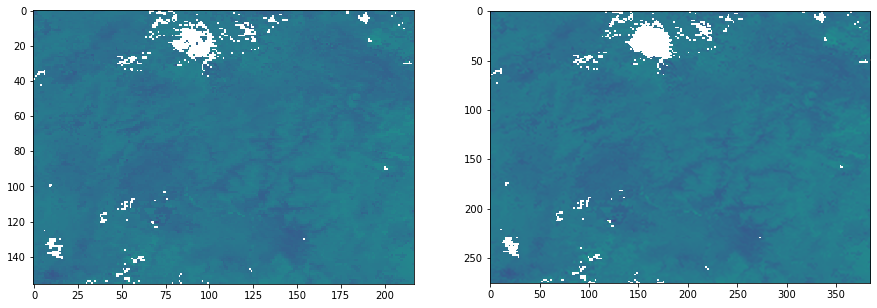

In [101]:
# example of erroneous value from lanczos resampling
# filepaths
reg_fp = os.path.join(temp_dir, "lanczos_example.tif")
mod_fp = glob.glob(os.path.join(mod_dir, "*MOD*2008001*.tif"))[0]
if os.path.exists(reg_fp):
    _ = os.unlink(reg_fp)
# warp and plot

arrs = warp_modis(arr, temp_meta, "lanczos", mod_fp, reg_fp)
plot_arrs(arrs[0], arrs[1])

Okay. This is not producing consistent results - sometimes the rasters have extreme high/low values in the nodata areas (looks like something some type of floating point errors), sometimes it's really just nodata (zeros). The true data in these rasters look the very similar though. But the following discrepancy is consistent (chose an iteration without the extreme values): 

In [78]:
print("max value of original raster:", np.nanmax(arrs[0]))
print("max value of regridded raster:", np.nanmax(arrs[1]))
print("min value of original raster:", np.nanmin(arrs[0]))
print("min value of regridded raster:", np.nanmin(arrs[1]))

max value of original raster: 258.7
max value of regridded raster: 288.76187
min value of original raster: 234.58
min value of regridded raster: 1.4887e-41


The new max value is over 20 Kelvin (i.e. over 20 degrees celsius) higher than the original max value. That's not good. Something similar appears to be happening with the minimum values. Additionally, there is something interpolating bands over large areas of nodata, which is also probably not ideal. 

Addressing this issue with thresholding is something that could probably be investigated, but it's probably best to just stick with a method that doesn't extrapolate, if at all possible. 

### Methods

Evaluate other resampling options offered by `gdalwarp` using statistical comparisons between the input and output rasters for a subset of the warped MODIS. Visually compare one pair for each method as well. 

In [72]:
# determine % of nodata cells in an array
def nan_perc(arr):
    return round(arr[np.isnan(arr)].size / arr.size, 2)

# compare summary statistics for two sets of arrays
# compute differences between min, max, mean, stdev, median, evaluate by mean and sd of these differences
def summarise_diffs(arrs):
    n = np.arange(len(arrs))
    d_min = [np.nanmin(arrs[i][0]) - np.nanmin(arrs[i][1]) for i in n]
    d_max = [np.nanmax(arrs[i][0]) - np.nanmax(arrs[i][1]) for i in n]
    d_std = [np.nanstd(arrs[i][0]) - np.nanstd(arrs[i][1]) for i in n]
    d_mean = [np.nanmean(arrs[i][0]) - np.nanmean(arrs[i][1]) for i in n]
    d_med = [np.nanmedian(arrs[i][0]) - np.nanmedian(arrs[i][1]) for i in n]
    d_nanperc = [nan_perc(arrs[i][0]) - nan_perc(arrs[i][1]) for i in n]
    d_all = d_min + d_max + d_std + d_mean + d_med + d_nanperc
    return(round(np.mean(d_all), 2), round(np.std(d_all), 2), sorted([abs(d) for d in d_all], reverse=True)[:5])

In [4]:
# all MODIS files 
mod_fps = glob.glob(os.path.join(mod_dir, "*MOD*01.tif"))
myd_fps = glob.glob(os.path.join(mod_dir, "*MYD*01.tif"))
in_fps = mod_fps + myd_fps
# subset
idx = np.arange(len(in_fps), step=100)
in_fps = [in_fps[i] for i in idx]

#### Nearest neighbor

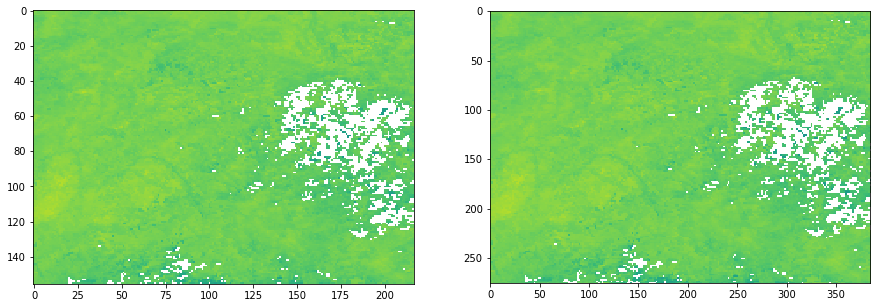

Nearest neighbor resampling differences from original, (mean, stdev): (4.72, 33.88)
Top 5 largest differences: [252.6  250.1    2.58   1.6    1.22]


In [73]:
method = "near"
out_fps = [
    os.path.join(temp_dir, "{}_{}_{}.tif".format(fp.split("_")[-6][-7:], fp.split("_")[-5][-7:], method)) 
    for fp in in_fps
]
arrs = [warp_modis(arr, temp_meta, method, in_fp, out_fp) for in_fp, out_fp in zip(in_fps, out_fps)]
results = summarise_diffs(arrs)
plot_arrs(arrs[0][0], arrs[0][1])
print("Nearest neighbor resampling differences from original, (mean, stdev):", results[:2])
print("Top 5 largest differences:", np.round(results[2], 2))

#### Bilinear

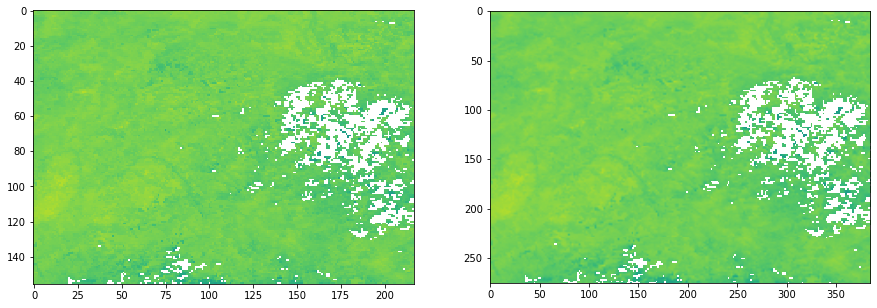

Bilinear resampling differences from original, (mean, stdev): [ 4.67 33.89]
Top 5 largest differences: [252.6  250.1    2.21   1.78   1.56]


In [74]:
method = "bilinear"
out_fps = [
    os.path.join(temp_dir, "{}_{}_{}.tif".format(fp.split("_")[-6][-7:], fp.split("_")[-5][-7:], method)) 
    for fp in in_fps
]
arrs = [warp_modis(arr, temp_meta, method, in_fp, out_fp) for in_fp, out_fp in zip(in_fps, out_fps)]
results = summarise_diffs(arrs)
plot_arrs(arrs[0][0], arrs[0][1])
print("Bilinear resampling differences from original, (mean, stdev):", np.round(results[:2], 2))
print("Top 5 largest differences:", np.round(results[2], 2))

#### Cubic

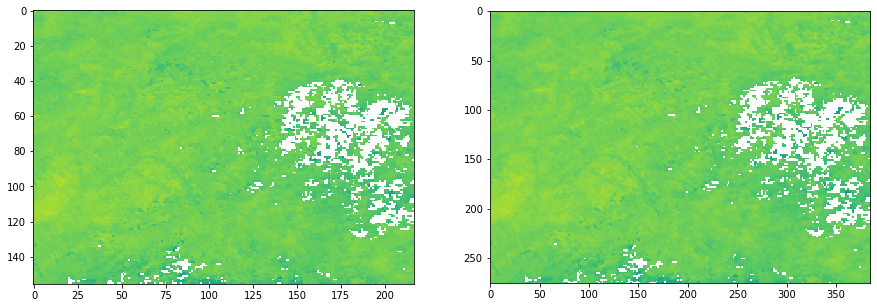

Cubic resampling differences from original, (mean, stdev): [ 4.62 33.9 ]
Top 5 largest differences: [252.6  250.1    3.03   2.88   2.71]


In [75]:
method = "cubic"
out_fps = [
    os.path.join(temp_dir, "{}_{}_{}.tif".format(fp.split("_")[-6][-7:], fp.split("_")[-5][-7:], method)) 
    for fp in in_fps
]
arrs = [warp_modis(arr, temp_meta, method, in_fp, out_fp) for in_fp, out_fp in zip(in_fps, out_fps)]
results = summarise_diffs(arrs)
plot_arrs(arrs[0][0], arrs[0][1])
print("Cubic resampling differences from original, (mean, stdev):", np.round(results[:2], 2))
print("Top 5 largest differences:", np.round(results[2], 2))

#### Lanczos

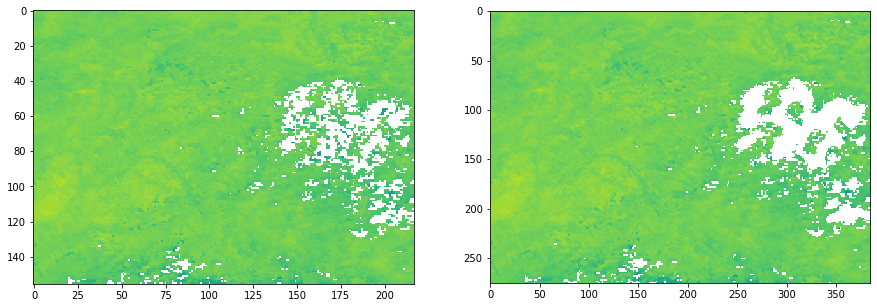

Lanczos resampling differences from original, (mean, stdev): [  3.46 106.28]
Top 5 largest differences: [875.67 556.62 252.6  250.1   93.46]


In [76]:
method = "lanczos"
out_fps = [
    os.path.join(temp_dir, "{}_{}_{}.tif".format(fp.split("_")[-6][-7:], fp.split("_")[-5][-7:], method)) 
    for fp in in_fps
]
arrs = [warp_modis(arr, temp_meta, method, in_fp, out_fp) for in_fp, out_fp in zip(in_fps, out_fps)]
results = summarise_diffs(arrs)
plot_arrs(arrs[0][0], arrs[0][1])
print("Lanczos resampling differences from original, (mean, stdev):", np.round(results[:2], 2))
print("Top 5 largest differences:", np.round(results[2], 2))

Tested `lanczos` just for comparison, clearly has issues extrapolating here. 

The default resampling method, nearest neighbors, is probably a safe bet, the others don't seem to be significantly better to justify.

In [81]:
# clear out temp stuff 
fps = glob.glob(os.path.join(temp_dir, "*"))
_ = [os.remove(fp) for fp in fps]
_ = os.rmdir(temp_dir)